### Librerias

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import seaborn as sns
import io
from contextlib import redirect_stdout
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D


In [240]:
import warnings
warnings.filterwarnings('ignore')

### Granger test Funciones

##### Calcular Granger para 1 variable con ventana movil

In [241]:
# Función para calcular el test de Granger a lo largo del tiempo
def granger_window_test(data, var_causa, var_efecto, ventana=30, lag = 1 ):
    n = len(data)
    resultados = pd.DataFrame({
        'date': pd.to_datetime(data.index),
        'p_value': [np.nan] * n
    })

    for i in range(ventana, n):
        subset_data = data.iloc[i - ventana + 1:i + 1]
        try:
            test = grangercausalitytests(subset_data[[var_causa, var_efecto]], maxlag=[lag], verbose=False)
            resultados.loc[i, 'p_value'] = test[1][0]['ssr_ftest'][1]
        except Exception as e:
            print(f"Error en el cálculo de Granger para el punto {i}: {str(e)}")
    resultados=resultados.dropna()
    return resultados

##### Grafica Granger simple

In [378]:
# Basic plot
"""def graficar_granger_test(data, var_causa, var_efecto, ventana=30):
    resultados = data.dropna()

    plt.figure(figsize=(12, 6))
    plt.axhline(y=0.05, color='black', linestyle='--')
    plt.scatter(resultados['date'], resultados['p_value'],
                c=['#CDAD00' if p < 0.05 else '#528B8B' for p in resultados['p_value']], s=1)

    plt.title(f"Causalidad de Granger: {var_causa} -> {var_efecto}")
    plt.suptitle(f"Ventana Movil = {ventana}", y=0.95)
    plt.xlabel("")
    plt.ylabel("Valor p")

    plt.legend(['', 'Influencia Potencial (p < 0.05)'], loc='lower center', bbox_to_anchor=(0.5, -0.15))
    plt.tight_layout()
    return plt"""

def granger_window_plot(data, var_causa, var_efecto, ventana=30):
    # Asegurarse de que los datos no tengan valores nulos
    resultados = data.dropna()

    # Configurar el estilo
    sns.set_style("whitegrid")  # Cambiamos a un estilo más limpio
    sns.set_palette("deep")

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(22, 12))  # Ajustado a una relación más ancha

    # Graficar los puntos
    scatter = ax.scatter(resultados['date'], resultados['p_value'],
                         c=['#FFD700' if p < 0.05 else '#4682B4' for p in resultados['p_value']], 
                         s=50, alpha=0.7, edgecolor='k')  # Puntos más grandes con borde negro

    # Añadir línea de umbral
    ax.axhline(y=0.05, color='#FF4500', linestyle='--', linewidth=2, alpha=0.7)

    # Configurar títulos y etiquetas
    fig.suptitle(f"Ventana Móvil = {ventana} días", 
                 fontsize=12, fontweight='bold', y=0.9)
    ax.set_title(f"Causalidad de Granger: {var_causa} → {var_efecto}", 
                 fontsize=24, style='italic', pad=22)

    ax.set_xlabel("Fecha", fontsize=14, labelpad=10)
    ax.set_ylabel("Valor p", fontsize=14, labelpad=10)

    # Configurar el formato de las fechas en el eje x
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Ajustar los límites del eje y
    ax.set_ylim(-0.05, 1.05)

    # Añadir leyenda
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Influencia Potencial (p < 0.05)',
                   markerfacecolor='#FFD700', markersize=10, markeredgecolor='k'),
        plt.Line2D([0], [0], marker='o', color='w', label='Sin Influencia Significativa',
                   markerfacecolor='#4682B4', markersize=10, markeredgecolor='k'),
        plt.Line2D([0], [0], color='#FF4500', lw=2, linestyle='--', label='Umbral (p = 0.05)')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              ncol=3, fontsize=12, frameon=True, facecolor='white', edgecolor='gray')

    # Ajustar los límites y el diseño
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.2)

    # Añadir una cuadrícula más sutil
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='#E0E0E0')
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='#F0F0F0')



##### Calculo y Grafica en 1 funcion

In [243]:
def granger_window_test_plot(data, var_causa, var_efecto, ventana=30):
    resultados=granger_window_test(data, var_causa, var_efecto, ventana)
    plot = granger_window_plot(resultados, var_causa, var_efecto, ventana)
    return plot

### Indice para test simple de 1 variable

In [244]:
def granger_index(data, max_val=10):
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))
    data['index'] = impacto(data['p_value'], max_val)
    data = data.dropna()
    return data

### Granger en ambas direcciones

In [291]:
def granger_window_comp(data, var1, var2, ventana=30, lag=1):
    n = len(data)
    resultados = pd.DataFrame({
        'date': pd.to_datetime(data.index),
        'p_value_1_2': [np.nan] * n, # Se guarda el valor p
        'p_value_2_1': [np.nan] * n, # Se guarda el valor p
    })
    
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))
    
    for i in range(ventana, n):
        subset_data = data.iloc[i - ventana + 1:i + 1]
        try:
            # Test de var1 causando var2
            test_2_1 = grangercausalitytests(subset_data[[var2, var1]], maxlag=[lag], verbose=False)
            p_value_2_1 = test_2_1[lag][0]['ssr_ftest'][1]
            
            # Test de var2 causando var1
            test_1_2 = grangercausalitytests(subset_data[[var1, var2]], maxlag=[lag], verbose=False)
            p_value_1_2 = test_1_2[lag][0]['ssr_ftest'][1]
            
            resultados.loc[i, 'p_value_1_2'] = p_value_1_2  # Se guarda el valor p
            resultados.loc[i, 'p_value_2_1'] = p_value_2_1  # Se guarda el valor p
        
        except Exception as e:
            print(f"Error en el cálculo de Granger para el punto {i}: {str(e)}")
    resultados = resultados.dropna()
    return resultados

###### Plot

In [377]:
def granger_window_comp_plot(data, var1, var2):
    # Asegurarse de que los datos no tengan valores nulos
    resultados = data.dropna()

    # Configurar el estilo
    sns.set_style("darkgrid")
    sns.set_palette("deep")

    # Crear la figura y los ejes para dos gráficos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 18))  # Crear 2 subplots (uno encima del otro)

    # Primer gráfico: var1 -> var2
    ax1.scatter(resultados['date'], resultados['p_value_1_2'],
                c=['#FFD700' if p < 0.05 else '#528B8B' for p in resultados['p_value_1_2']], 
                s=50, edgecolor=None)

    ax1.axhline(y=0.05, color='#1A1A1A', linestyle='--', linewidth=2, alpha=0.7)
    ax1.set_title(f"Causalidad de Granger: {var1} causa {var2}", fontsize=24, style='italic', pad=22)
    ax1.set_xlabel(None, fontsize=14, labelpad=10)
    ax1.set_ylabel("Valor p", fontsize=14, labelpad=10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.WeekdayLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, which='major', linestyle='-', linewidth=0.5, color='#E0E0E0')
    ax1.grid(True, which='minor', linestyle=':', linewidth=0.5, color='#F0F0F0')

    # Segundo gráfico: var2 -> var1
    ax2.scatter(resultados['date'], resultados['p_value_2_1'],
                c=['#FFD700' if p < 0.05 else '#528B8B' for p in resultados['p_value_2_1']], 
                s=50, edgecolor=None)

    ax2.axhline(y=0.05, color='#1A1A1A', linestyle='--', linewidth=2, alpha=0.7)
    ax2.set_title(f"Causalidad de Granger: {var2} causa {var1}", fontsize=24, style='italic', pad=22)
    ax2.set_xlabel(None, fontsize=14, labelpad=10)
    ax2.set_ylabel("Valor p", fontsize=14, labelpad=10)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax2.xaxis.set_minor_locator(mdates.WeekdayLocator())
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax2.set_ylim(-0.05, 1.05)
    ax2.grid(True, which='major', linestyle='-', linewidth=0.5, color='#E0E0E0')
    ax2.grid(True, which='minor', linestyle=':', linewidth=0.5, color='#F0F0F0')

    # Leyenda compartida para ambos gráficos
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Influencia Potencial (p < 0.05)',
                   markerfacecolor='#FFD700', markersize=10, markeredgecolor='k'),
        plt.Line2D([0], [0], marker='o', color='w', label='Sin Influencia Significativa',
                   markerfacecolor='#528B8B', markersize=10, markeredgecolor='k'),
        plt.Line2D([0], [0], color='#1A1A1A', lw=2, linestyle='--', label='Umbral (p = 0.05)')
    ]
    ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=3, fontsize=12, frameon=True, facecolor='white', edgecolor='gray')

    # Ajustar el diseño para que no se superpongan los elementos
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.15, hspace=0.5)

    # Mostrar la gráfica
    plt.show()

### Indice en ambas direcciones

###### Get index

In [302]:
def granger_window_comp_index(data, max_val=5):
    # Crear un DataFrame con las mismas fechas y columnas de salida
    resultados = pd.DataFrame({
        'date': data['date'],
        'p_value_1_2': data['p_value_1_2'],
        'p_value_2_1': data['p_value_2_1'],
        'indicador_1_2': [np.nan] * len(data),
        'indicador_2_1': [np.nan] * len(data)
    })
    
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))
    
    # Calcular los indicadores usando los p-values 
    resultados['indicador_1_2'] = impacto(data['p_value_1_2'], max_val)
    resultados['indicador_2_1'] = impacto(data['p_value_2_1'], max_val)
    
    resultados = resultados.dropna()
    return resultados

###### Full execution method

In [245]:
def granger_window_comp_index_all(data, var1, var2, ventana=30, lag=1, max_val=5):
    n = len(data)
    resultados = pd.DataFrame({
        'date': pd.to_datetime(data.index),
       # 'p_value_1_2': [np.nan] * n, # Se guarda el valor p
       # 'p_value_2_1': [np.nan] * n, # Se guarda el valor p
        'indicador_1_2': [np.nan] * n,
        'indicador_2_1': [np.nan] * n
    })
    
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))
    
    for i in range(ventana, n):
        subset_data = data.iloc[i - ventana + 1:i + 1]
        try:
            # Test de var1 causando var2
            test_2_1 = grangercausalitytests(subset_data[[var2, var1]], maxlag=[lag], verbose=False)
            p_value_2_1 = test_2_1[lag][0]['ssr_ftest'][1]
            
            # Test de var2 causando var1
            test_1_2 = grangercausalitytests(subset_data[[var1, var2]], maxlag=[lag], verbose=False)
            p_value_1_2 = test_1_2[lag][0]['ssr_ftest'][1]
            
         #   resultados.loc[i, 'p_value_1_2'] = p_value_1_2  # Se guarda el valor p
         #   resultados.loc[i, 'p_value_2_1'] = p_value_2_1  # Se guarda el valor p
            
            # Cálculo de los indicadores
            resultados.loc[i, 'indicador_1_2'] = impacto(p_value_1_2, max_val)
            resultados.loc[i, 'indicador_2_1'] = impacto(p_value_2_1, max_val)
        
        except Exception as e:
            print(f"Error en el cálculo de Granger para el punto {i}: {str(e)}")
    resultados = resultados.dropna()
    return resultados

###### 2 graficas

In [301]:
def granger_comp_index_sep_plots(resultados, var1, var2, color1='red', color2='blue'):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
    
    # Crear mapa de colores personalizado
    cmap1 = LinearSegmentedColormap.from_list("custom", ['darkgray', 'lightgray', color1])
    cmap2 = LinearSegmentedColormap.from_list("custom", ['darkgray', 'lightgray', color2])

    
    # Función para asignar colores       
    def asignar_color(valor, cmap):
        if valor <= 1:
            return cmap(valor / 2)  # Usar la mitad inferior del mapa de colores para valores <= 1
        else:
            return cmap(0.5 + min(valor - 1, 1) / 2)  # Usar la mitad superior para valores > 1
    
    # Graficar puntos para var1 causando var2
    colors_1_2 = [asignar_color(v, cmap1) for v in resultados['indicador_1_2']]
    scatter1 = ax1.scatter(resultados['date'], resultados['indicador_1_2'], c=colors_1_2, s=10)
    
    # Graficar puntos para var2 causando var1
    colors_2_1 = [asignar_color(v, cmap2) for v in resultados['indicador_2_1']]
    scatter2 = ax2.scatter(resultados['date'], resultados['indicador_2_1'], c=colors_2_1, s=10)
    
    # Configuración de los gráficos
    for ax in [ax1, ax2]:
        ax.axhline(y=1, color='#030303', linestyle='--')
        ax.set_ylabel('Impacto (> 1 indica posible causalidad)')
        ax.set_ylim(0, min(5, max(resultados['indicador_1_2'].max(), resultados['indicador_2_1'].max())))
    
    ax1.set_title(f'Indicador de Causalidad de Granger: {var1} -> {var2}', fontsize=24)
    ax2.set_title(f'Indicador de Causalidad de Granger: {var2} -> {var1}', fontsize=24)
    ax2.set_xlabel('Fecha')
    
    # Crear leyendas personalizadas
    legend_elements1 = [
        Line2D([0], [0], marker='o', color='w', label=f'{var1} causa {var2} (puntos)',
               markerfacecolor=color1, markersize=10),
        Line2D([0], [0], color='#030303', linestyle='--', label='Umbral (p-value = 0.05)')
    ]
    legend_elements2 = [
        Line2D([0], [0], marker='o', color='w', label=f'{var2} causa {var1} (puntos)',
               markerfacecolor=color2, markersize=10),
        Line2D([0], [0], color='#030303', linestyle='--', label='Umbral (p-value = 0.05)')
    ]
    
    ax1.legend(handles=legend_elements1, loc='upper left')
    ax2.legend(handles=legend_elements2, loc='upper left')
    
    plt.tight_layout()
    plt.show()

###### 1 grafica comparativa

In [376]:
def granger_comp_index_plot2(resultados, var1, var2, color1='#008B8B', color2='#FFB90F'):
    fig, ax = plt.subplots(figsize=(22, 12))
    
    # Graficar puntos y líneas para var1 causando var2 con color fijo
    ax.scatter(resultados['date'], resultados['indicador_1_2'], 
               color=color1, s=50, label=f'{var1} causa {var2} (puntos)')
    
    # Graficar puntos y líneas para var2 causando var1 con color fijo
    ax.scatter(resultados['date'], resultados['indicador_2_1'], 
               color=color2, s=50, label=f'{var2} causa {var1} (puntos)')
    
    # Configuración del gráfico
    ax.axhline(y=1, color='#030303', linestyle='--', label='Umbral (p-value = 0.05)')
    ax.set_ylabel('Impacto (> 1 indica posible causalidad)', fontsize=14)
    ax.set_xlabel(None)
    ax.legend(loc='upper right')
    ax.set_ylim(0, min(5, max(resultados['indicador_1_2'].max(), resultados['indicador_2_1'].max())))
    
    ax.set_title(f'Indicador de Causalidad de Granger: {var1} <-> {var2}', fontsize=24)
    
    # Formato de fecha en el eje x
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()  # Rota y alinea las etiquetas de fecha
    
    plt.tight_layout()
    plt.show()

def granger_comp_index_plot(resultados, var1, var2, max_val=5, color1='#008B8B', color2='#FFB90F'):
    fig, ax = plt.subplots(figsize=(22, 12))
    
    # Crear mapas de colores personalizados
    cmap1 = LinearSegmentedColormap.from_list("custom1", ['darkgray', 'lightgray', color1])
    cmap2 = LinearSegmentedColormap.from_list("custom2", ['darkgray', 'lightgray', color2])
    
    # Función para asignar colores
    def asignar_color(valor, cmap):
        if valor <= 1:
            return cmap(valor / 2)  # Usar la mitad inferior del mapa de colores para valores <= 1
        else:
            return cmap(0.5 + min(valor - 1, 1) / 2)  # Usar la mitad superior para valores > 1
    
    # Graficar puntos para var1 causando var2
    colors_1_2 = [asignar_color(v, cmap1) for v in resultados['indicador_1_2']]
    ax.scatter(resultados['date'], resultados['indicador_1_2'], c=colors_1_2, s=50)
    
    # Graficar puntos para var2 causando var1
    colors_2_1 = [asignar_color(v, cmap2) for v in resultados['indicador_2_1']]
    ax.scatter(resultados['date'], resultados['indicador_2_1'], c=colors_2_1, s=50)
    
    # Configuración del gráfico
    ax.axhline(y=1, color='#030303', linestyle='--')
    ax.set_ylabel('Impacto (> 1 indica posible causalidad)', fontsize=14)
    ax.set_xlabel(None, fontsize=14)
    ax.set_ylim(0, min(max_val, max(resultados['indicador_1_2'].max(), resultados['indicador_2_1'].max())))
    
    ax.set_title(f'Indicador de Causalidad de Granger: {var1} <-> {var2}', fontsize=24)
    
    # Crear leyenda personalizada
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'{var1} -> {var2}',
               markerfacecolor=color1, markersize=10),
        Line2D([0], [0], marker='o', color='w', label=f'{var2} -> {var1}',
               markerfacecolor=color2, markersize=10),
        Line2D([0], [0], color='#030303', linestyle='--', label='Umbral (p-value = 0.05)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    # Añadir leyendas de color
    """sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=0, vmax=max_val))
    sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=max_val))
    sm1._A = []  # Hack para arreglar el escalado
    sm2._A = []
    cbar1 = plt.colorbar(sm1, ax=ax, orientation='horizontal', pad=0, aspect=50, shrink=0.5)
    cbar2 = plt.colorbar(sm2, ax=ax, orientation='horizontal', pad=0.05, aspect=50, shrink=0.5)
    cbar1.set_label(f'{var1} -> {var2}', fontsize=12)
    cbar2.set_label(f'{var2} -> {var1}', fontsize=12)"""
    
    plt.tight_layout()
    plt.show()

### Oscilador con barras

Arriba = VAR1 causa VAR2

Abajo  = VAR2 causa VAR1

In [303]:
def granger_oscillator(data, max_val=10):
    n = len(data)
    resultados = pd.DataFrame({
        'date': data['date'],
        'p_value_1_2': data['p_value_1_2'],
        'p_value_2_1': data['p_value_2_1'],
        'oscilador_1_2': [np.nan] * n,
        'oscilador_2_1': [np.nan] * n
    })
    
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))
    
    # Calcular los osciladores usando los p-values 
    resultados['oscilador_1_2'] = impacto(data['p_value_1_2'], max_val)
    resultados['oscilador_2_1'] = -impacto(data['p_value_2_1'], max_val)  # negativo para que aparezca abajo
    resultados = resultados.dropna()
    return resultados

###### Full execution method

In [248]:
def granger_oscillator_all(data, var1, var2, ventana=30, lag=1, max_val=10):
    n = len(data)
    resultados = pd.DataFrame({
        'date': pd.to_datetime(data.index),
        'oscilador_1_2': [np.nan] * n,
        'oscilador_2_1': [np.nan] * n
    })
    
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))

    for i in range(ventana, n):
        subset_data = data.iloc[i - ventana + 1:i + 1]
        try:
            # Test de var1 causando var2
            test_2_1 = grangercausalitytests(subset_data[[var2, var1]], maxlag=[lag], verbose=False)
            p_value_2_1 = test_2_1[lag][0]['ssr_ftest'][1]
            
            # Test de var2 causando var1
            test_1_2 = grangercausalitytests(subset_data[[var1, var2]], maxlag=[lag], verbose=False)
            p_value_1_2 = test_1_2[lag][0]['ssr_ftest'][1]
                        
            # Cálculo de los osciladores usando la fórmula
            resultados.loc[i, 'oscilador_1_2'] = impacto(p_value_1_2, max_val)
            resultados.loc[i, 'oscilador_2_1'] = -impacto(p_value_2_1, max_val)  # negativo para que aparezca abajo
        
        except Exception as e:
            print(f"Error en el cálculo de Granger para el punto {i}: {str(e)}")
    
    return resultados

###### Oscillator plot

In [381]:
def granger_oscillator_plot(resultados, var1, var2):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)  # Ajuste de DPI para mejorar la resolución
    
    # Gráfico de barras con ajuste de ancho
    ax.bar(resultados['date'], resultados['oscilador_1_2'], color='#528B8B', 
           label=f'{var1} causa {var2}', alpha=0.7, width=1, edgecolor='none')
    ax.bar(resultados['date'], resultados['oscilador_2_1'], color='#EEAD0E', 
           label=f'{var2} causa {var1}', alpha=0.7, width=1, edgecolor='none')
    
    # Línea de referencia en 0
    ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Líneas de significancia (p=0.05)
    ax.axhline(1, color='red', linestyle=':', linewidth=0.8, label='Significancia (p=0.05)')
    ax.axhline(-1, color='red', linestyle=':', linewidth=0.8)
    
    # Etiquetas y título
    ax.set_xlabel(None)
    ax.set_ylabel('Indicador de Impacto')
    ax.set_title('Oscilador de Impacto Causalidad de Granger', fontweight='bold', fontsize=24)
    
    # Configuración de la leyenda
    ax.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    # Formato de fecha en el eje x
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()  # Rota y alinea las etiquetas de fecha
    
    plt.tight_layout()
    plt.show()

### Indice de Impacto bidireccional

Arriba = VAR1 causa VAR2

Abajo  = VAR2 causa VAR1

In [328]:
def impact_index(data):
    # Crear el DataFrame de resultados
    resultados = pd.DataFrame({
        'fecha': data['date'],
        'p_value_1_2': data['p_value_1_2'],
        'p_value_2_1': data['p_value_2_1'],
        'indice_impacto': [np.nan] * len(data)
    })
    
    # Calcular el índice de impacto
    for i in range(len(data)):
        p_value_1_2 = data.iloc[i]['p_value_1_2']
        p_value_2_1 = data.iloc[i]['p_value_2_1']
        
        if p_value_1_2 < p_value_2_1:
            # var1 impacta más a var2
            indice = np.log10(p_value_1_2)
        else:
            # var2 impacta más a var1 o no hay diferencia significativa
            indice = -np.log10(p_value_2_1)
        
        resultados.loc[i, 'indice_impacto'] = indice
    
    return resultados

In [250]:
def impact_index_all(data, var1, var2, ventana=30):
    n = len(data)
    resultados = pd.DataFrame({
        'fecha': range(n),
        'indice_impacto': [np.nan] * n
    })
    
    for i in range(ventana, n):
        subset_data = data.iloc[i - ventana + 1:i + 1]
        try:
            # Test de Granger de var_causa -> var_efecto
            test_1_2 = grangercausalitytests(subset_data[[var1, var2]], maxlag=[1], verbose=False)
            p_value_1_2 = test_1_2[1][0]['ssr_ftest'][1]
            
            # Test de Granger de var_efecto -> var_causa
            test_2_1 = grangercausalitytests(subset_data[[var2, var1]], maxlag=[1], verbose=False)
            p_value_2_1 = test_2_1[1][0]['ssr_ftest'][1]
            
            # Calcular el índice de impacto
            if p_value_1_2 < p_value_2_1:
                # var_causa impacta más a var_efecto
                indice = np.log10(p_value_1_2)
            else:
                # var_efecto impacta más a var_causa o no hay diferencia significativa
                indice = -np.log10(p_value_2_1)
            
            resultados.loc[i, 'indice_impacto'] = indice
        
        except Exception as e:
            print(f"Error en el cálculo para el punto {i}: {str(e)}")
    
    resultados['fecha'] = pd.to_datetime(data.index)
    resultados = resultados.dropna()
    return resultados

In [379]:
# Base plot
"""def impact_index_plot(resultados, var_causa, var_efecto):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(resultados['fecha'], resultados['indice_impacto'], color='#668B8B', label='Índice de Impacto')
    
    # Añadir líneas horizontales para los niveles de impacto
    ax.axhline(y=1.3, color='#8B8989', linestyle='--', label='Impacto significativo')
    ax.axhline(y=-1.3, color='#8B8989', linestyle='--')
    
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    ax.set_title(f'Índice de Impacto: {var_causa} vs {var_efecto}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Índice de Impacto')
    ax.legend()
    
    # Añadir anotaciones
    ax.text(resultados['fecha'].iloc[-1], 1.35, f'{var_causa} impacta {var_efecto}', 
            horizontalalignment='right', verticalalignment='bottom')
    ax.text(resultados['fecha'].iloc[-1], -1.35, f'{var_efecto} impacta {var_causa}', 
            horizontalalignment='right', verticalalignment='top')
    
    plt.tight_layout()
    plt.show()"""
    
def impact_index_plot(resultados, var1, var2):
    # Configurar el estilo
    sns.set_style("whitegrid")
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(14, 7))  # Tamaño de la figura ligeramente más grande

    # Graficar el Índice de Impacto
    ax.plot(resultados['fecha'], resultados['indice_impacto'], color='#36648B', linewidth=1.5, label='Índice de Impacto')

    # Añadir líneas horizontales para los niveles de impacto
    ax.axhline(y=1.3, color='#8B3A3A', linestyle='--', linewidth=1, label='Impacto Significativo')
    ax.axhline(y=-1.3, color='#8B3A3A', linestyle='--', linewidth=1)
    
    # Línea en y=0 para referencia
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

    # Configurar título y etiquetas
    ax.set_title(f'Índice de Impacto por Causalidad de Granger: {var1} vs {var2}', fontsize=24, fontweight='bold', pad=20)
    ax.set_xlabel(None, fontsize=14, labelpad=10)
    ax.set_ylabel('Índice de Impacto', fontsize=14, labelpad=10)

    # Formatear eje X para fechas
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Añadir anotaciones
    ax.annotate(f'{var1} causa {var2}', 
                xy=(resultados['fecha'].max(), 1.35), xytext=(-30, 10),
                textcoords='offset points', ha='right', fontsize=12, color='#8B0000')

    ax.annotate(f'{var2} causa {var1}', 
                xy=(resultados['fecha'].max(), -1.35), xytext=(-30, -20),
                textcoords='offset points', ha='right', fontsize=12, color='#8B0000')

    # Añadir leyenda
    ax.legend(loc='upper right')

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

### Log rends

In [252]:
def calcular_rendimientos_logaritmicos(data, date_column = "date", date_format='%d/%m/%Y'):
    # Verificar si la primera columna es 'date' y si no es el índice
    if data.columns[0] == date_column and data.index.name != date_column:
        # Asegurarse de que la primera columna sea de tipo datetime
        data['date'] = pd.to_datetime(data['date'], format=date_format)
        data.set_index(date_column, inplace=True)
    
    data_rlog = np.log(data / data.shift(1))
    data_rlog = data_rlog.dropna()
    
    return data_rlog

### Preparacion de datos

##### Read and clean raw prices data

In [253]:
data = pd.read_csv("crypto.csv/crypto.csv")
# Seleccionar columnas que contengan prefijo "_close"
data_cl = data.filter(items=['date']).join(data.filter(like='close'))
names = {col: col.replace('USDT_close', '') for col in data_cl.columns}
data_cl = data_cl.rename(columns=names)
data_cl['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
data_cl = data_cl.set_index('date')
data_cl.head()

,BTC,ETH,TRX,XRP,SOL,CRV,ZIL,ICX,IOTA,BAND,...,COMP,THETA,ATOM,SNX,VET,QTUM,YFI,BNB,EGLD,LTC
date,,,,,,,,,,,,,,,,,,,,,
2020-09-04 06:00:00,10226.36,382.70,0.04261,0.24742,3.5000,2.814,0.01592,0.4310,0.2741,10.0000,...,189.91,0.38380,4.900,5.153,0.012144,2.369,28221.18,20.3501,17.027,48.21
2020-09-04 07:00:00,10295.59,386.01,0.04258,0.24923,3.5284,2.919,0.01591,0.4312,0.2776,10.0055,...,192.69,0.38484,4.915,5.248,0.012276,2.313,28204.80,20.3055,17.129,48.83
2020-09-04 08:00:00,10421.99,395.65,0.04186,0.25228,3.7211,3.171,0.01635,0.4459,0.2881,10.7356,...,196.03,0.39360,5.228,5.360,0.013178,2.430,29350.47,21.2413,17.277,49.67
2020-09-04 09:00:00,10518.38,399.86,0.04004,0.25640,3.7989,3.282,0.01684,0.4585,0.2949,11.3890,...,197.95,0.41300,5.455,5.538,0.013953,2.582,29306.12,21.5506,17.121,51.45
2020-09-04 10:00:00,10462.26,395.00,0.03861,0.26006,3.6701,3.157,0.01703,0.4539,0.2912,11.4400,...,197.09,0.41584,5.404,5.475,0.014023,2.548,29259.86,21.2299,17.342,51.42


##### Log hourly and daily data

In [254]:
# obtener rendimientos log
data_rlog = calcular_rendimientos_logaritmicos(data_cl)
data_rlog.head()

,BTC,ETH,TRX,XRP,SOL,CRV,ZIL,ICX,IOTA,BAND,...,COMP,THETA,ATOM,SNX,VET,QTUM,YFI,BNB,EGLD,LTC
date,,,,,,,,,,,,,,,,,,,,,
2020-09-04 07:00:00,0.006747,0.008612,-0.000704,0.007289,0.008082,0.036634,-0.000628,0.000464,0.012688,0.000550,...,0.014532,0.002706,0.003057,0.018268,0.010811,-0.023923,-0.000581,-0.002194,0.005973,0.012778
2020-09-04 08:00:00,0.012202,0.024667,-0.017054,0.012163,0.053175,0.082806,0.027280,0.033523,0.037126,0.070430,...,0.017185,0.022508,0.061737,0.021117,0.070903,0.049346,0.039816,0.045056,0.008603,0.017056
2020-09-04 09:00:00,0.009206,0.010585,-0.044452,0.016199,0.020692,0.034406,0.029529,0.027866,0.023329,0.059083,...,0.009747,0.048112,0.042504,0.032669,0.057146,0.060673,-0.001512,0.014456,-0.009070,0.035209
2020-09-04 10:00:00,-0.005350,-0.012229,-0.036368,0.014174,-0.034493,-0.038831,0.011219,-0.010083,-0.012626,0.004468,...,-0.004354,0.006853,-0.009393,-0.011441,0.005004,-0.013256,-0.001580,-0.014993,0.012826,-0.000583
2020-09-04 11:00:00,-0.003839,-0.000937,0.032865,-0.011447,-0.026897,-0.015321,-0.008847,-0.007075,0.006162,-0.033492,...,-0.015905,-0.014143,-0.006684,-0.007333,-0.011620,0.006650,-0.022208,0.007686,0.067392,-0.005851


In [306]:
# obtener datos de cierre diarios y calcular rendimientos logaritmicos
data_d = data_cl.resample('D').last()
data_d_rlog = calcular_rendimientos_logaritmicos(data_d)
data_d_rlog.head()

,BTC,ETH,TRX,XRP,SOL,CRV,ZIL,ICX,IOTA,BAND,...,COMP,THETA,ATOM,SNX,VET,QTUM,YFI,BNB,EGLD,LTC
date,,,,,,,,,,,,,,,,,,,,,
2020-09-05,-0.027126,-0.139758,-0.172907,-0.067081,-0.303817,-0.404939,-0.104758,-0.100962,-0.087861,-0.291091,...,-0.170439,-0.075273,-0.105096,-0.175891,-0.164731,-0.095155,-0.207524,-0.074286,-0.355627,-0.050750
2020-09-06,0.008766,0.051741,0.050255,0.010393,0.171988,0.127728,0.022503,0.053916,0.078821,0.166640,...,0.078887,0.079507,0.051517,0.102561,0.020692,0.032735,0.069764,0.172785,0.081559,0.001880
2020-09-07,0.011366,0.002237,0.033488,0.008800,-0.056647,-0.029600,0.002614,-0.032328,-0.006659,-0.034060,...,0.048832,-0.024595,-0.024437,-0.064821,-0.012462,-0.004967,-0.034709,-0.030688,-0.011209,0.019017
2020-09-08,-0.024078,-0.046899,0.079545,-0.022611,-0.169442,-0.131286,0.014901,-0.054250,-0.027448,-0.090254,...,-0.034651,-0.042435,-0.020191,-0.089599,-0.006743,-0.021389,-0.020522,0.036793,0.059329,-0.028452
2020-09-09,0.009098,0.039119,-0.035000,0.010261,0.377554,0.070333,0.057480,0.031462,0.031308,0.029518,...,0.025637,0.180626,0.071682,0.162260,0.057869,0.033350,0.199854,0.049760,0.072651,0.007346


### Aplicar granger

In [309]:
res = granger_window_comp(data_d_rlog, 'BTC', 'ETH', ventana=30, lag=1)
res.head()

,date,p_value_1_2,p_value_2_1
30,2020-10-05,0.494585,0.733090
31,2020-10-06,0.421456,0.675752
32,2020-10-07,0.320524,0.816998
33,2020-10-08,0.307866,0.942663
34,2020-10-09,0.215339,0.716932


In [ ]:
pvalue_1h = granger_window_comp(data_rlog, 'BTC', 'ETH', ventana=24, lag=1)
pvalue_1h.head()

### Graficas Diarias

#### Grafica de Valores-p

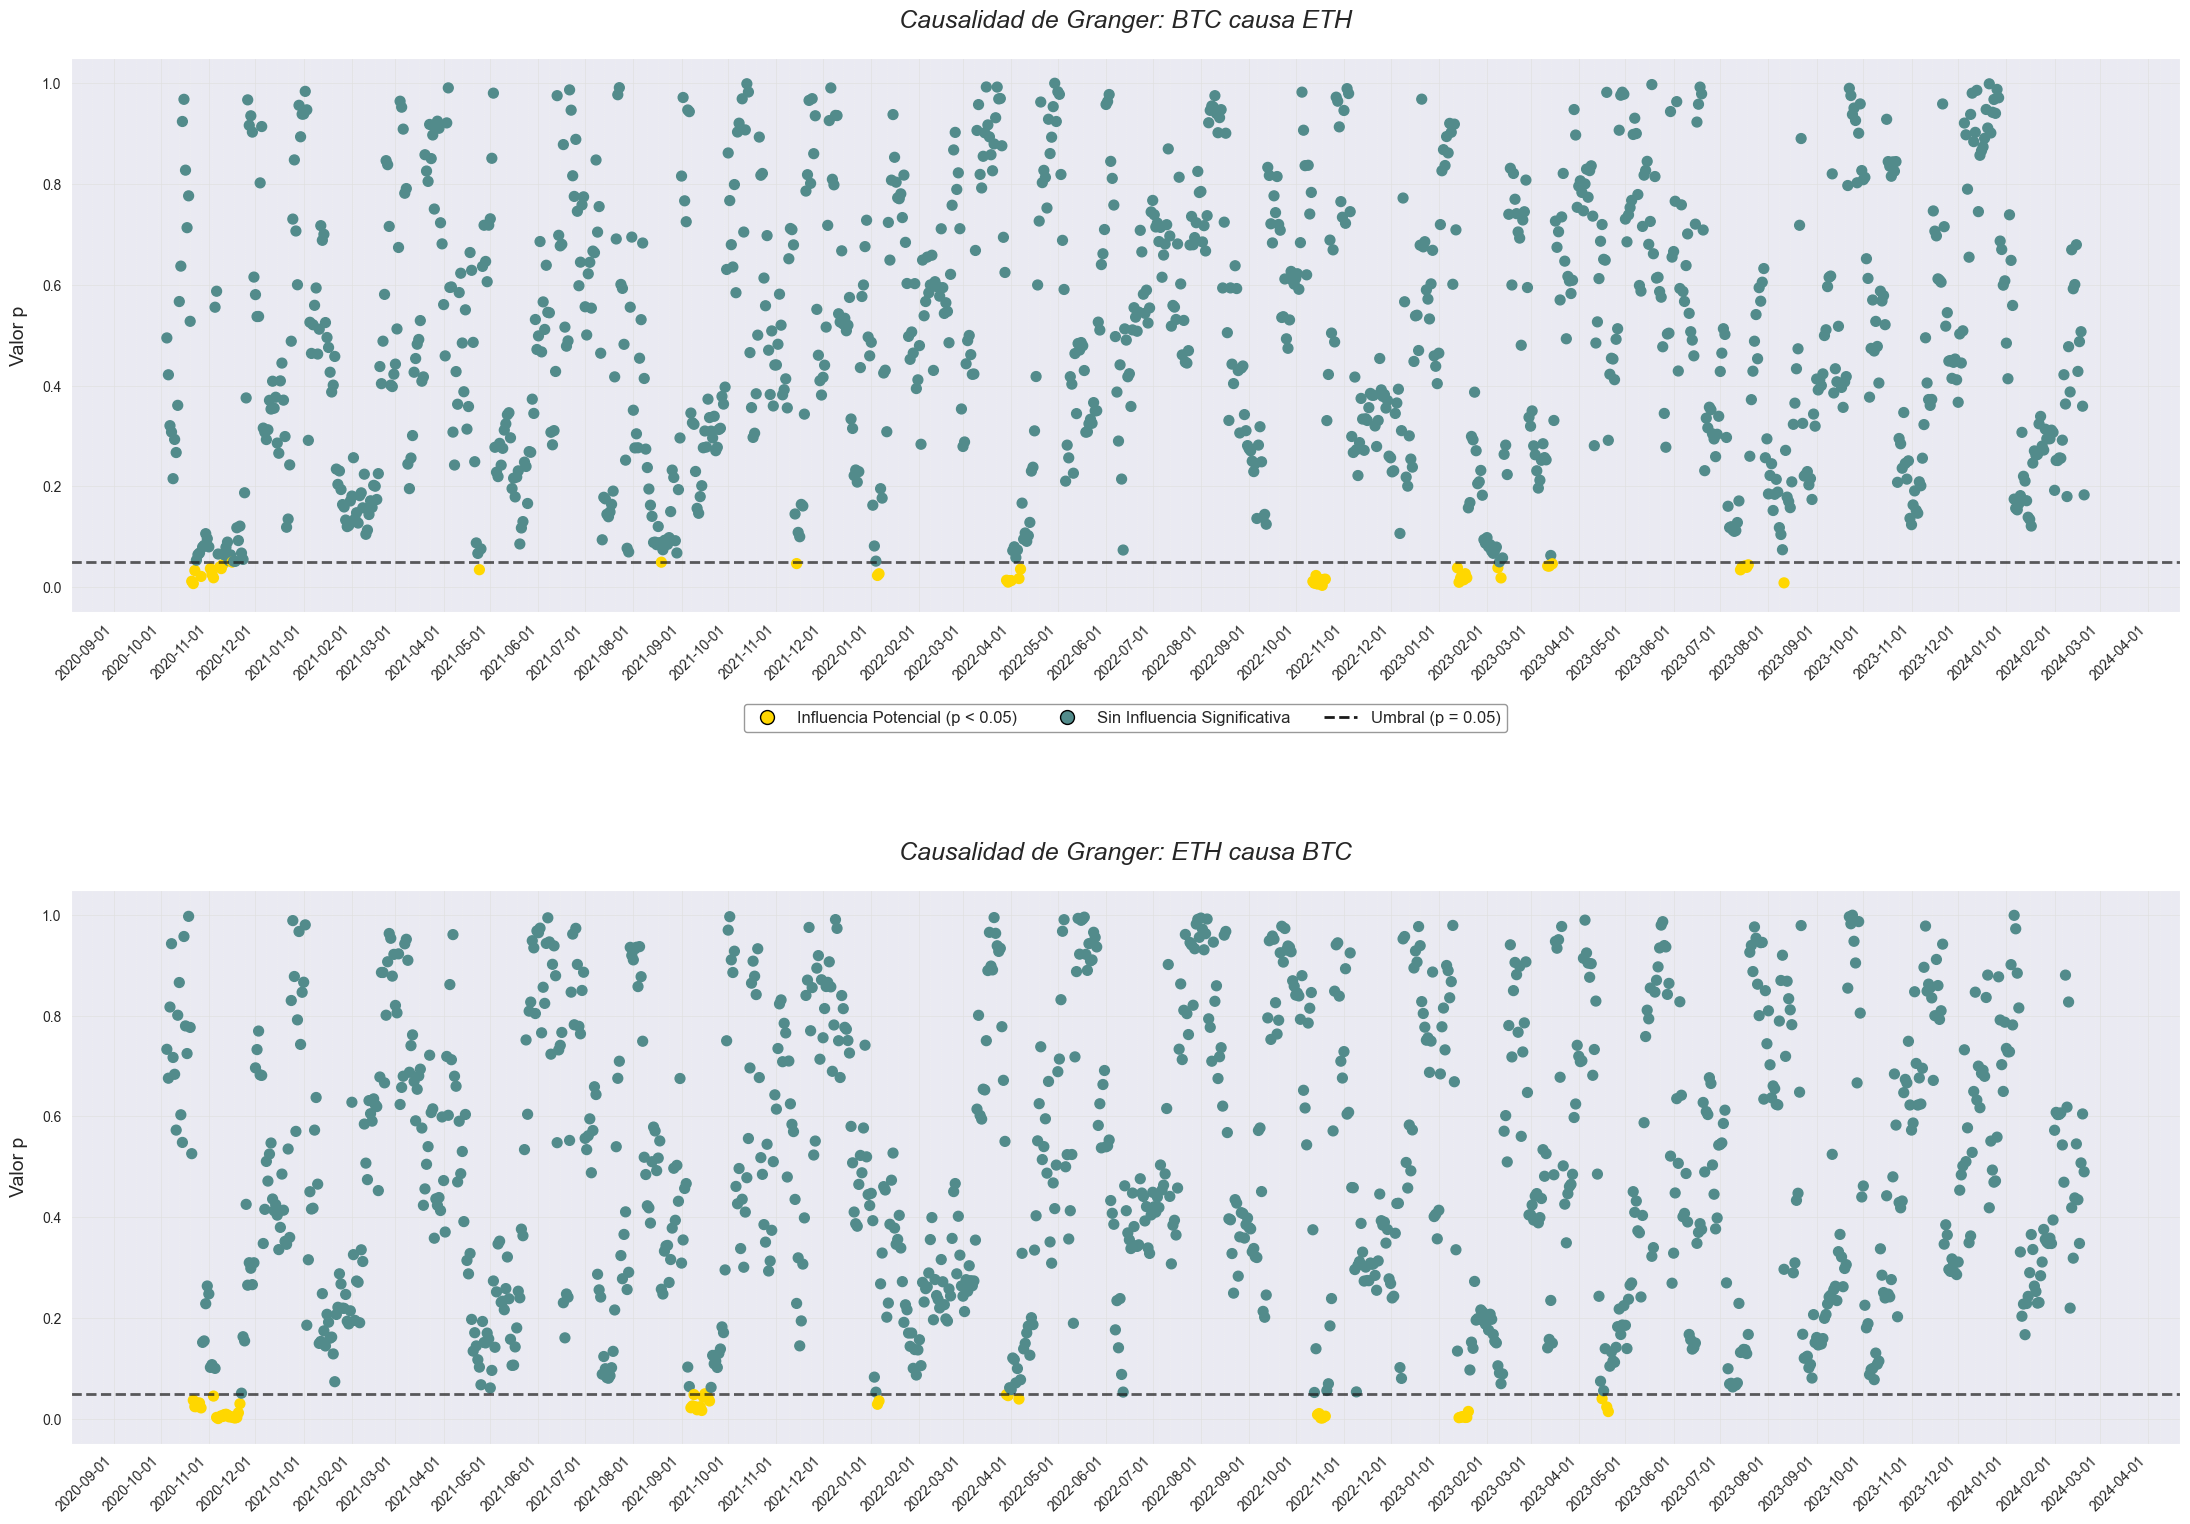

In [368]:
granger_window_comp_plot(res, 'BTC', 'ETH')

#### Indicador

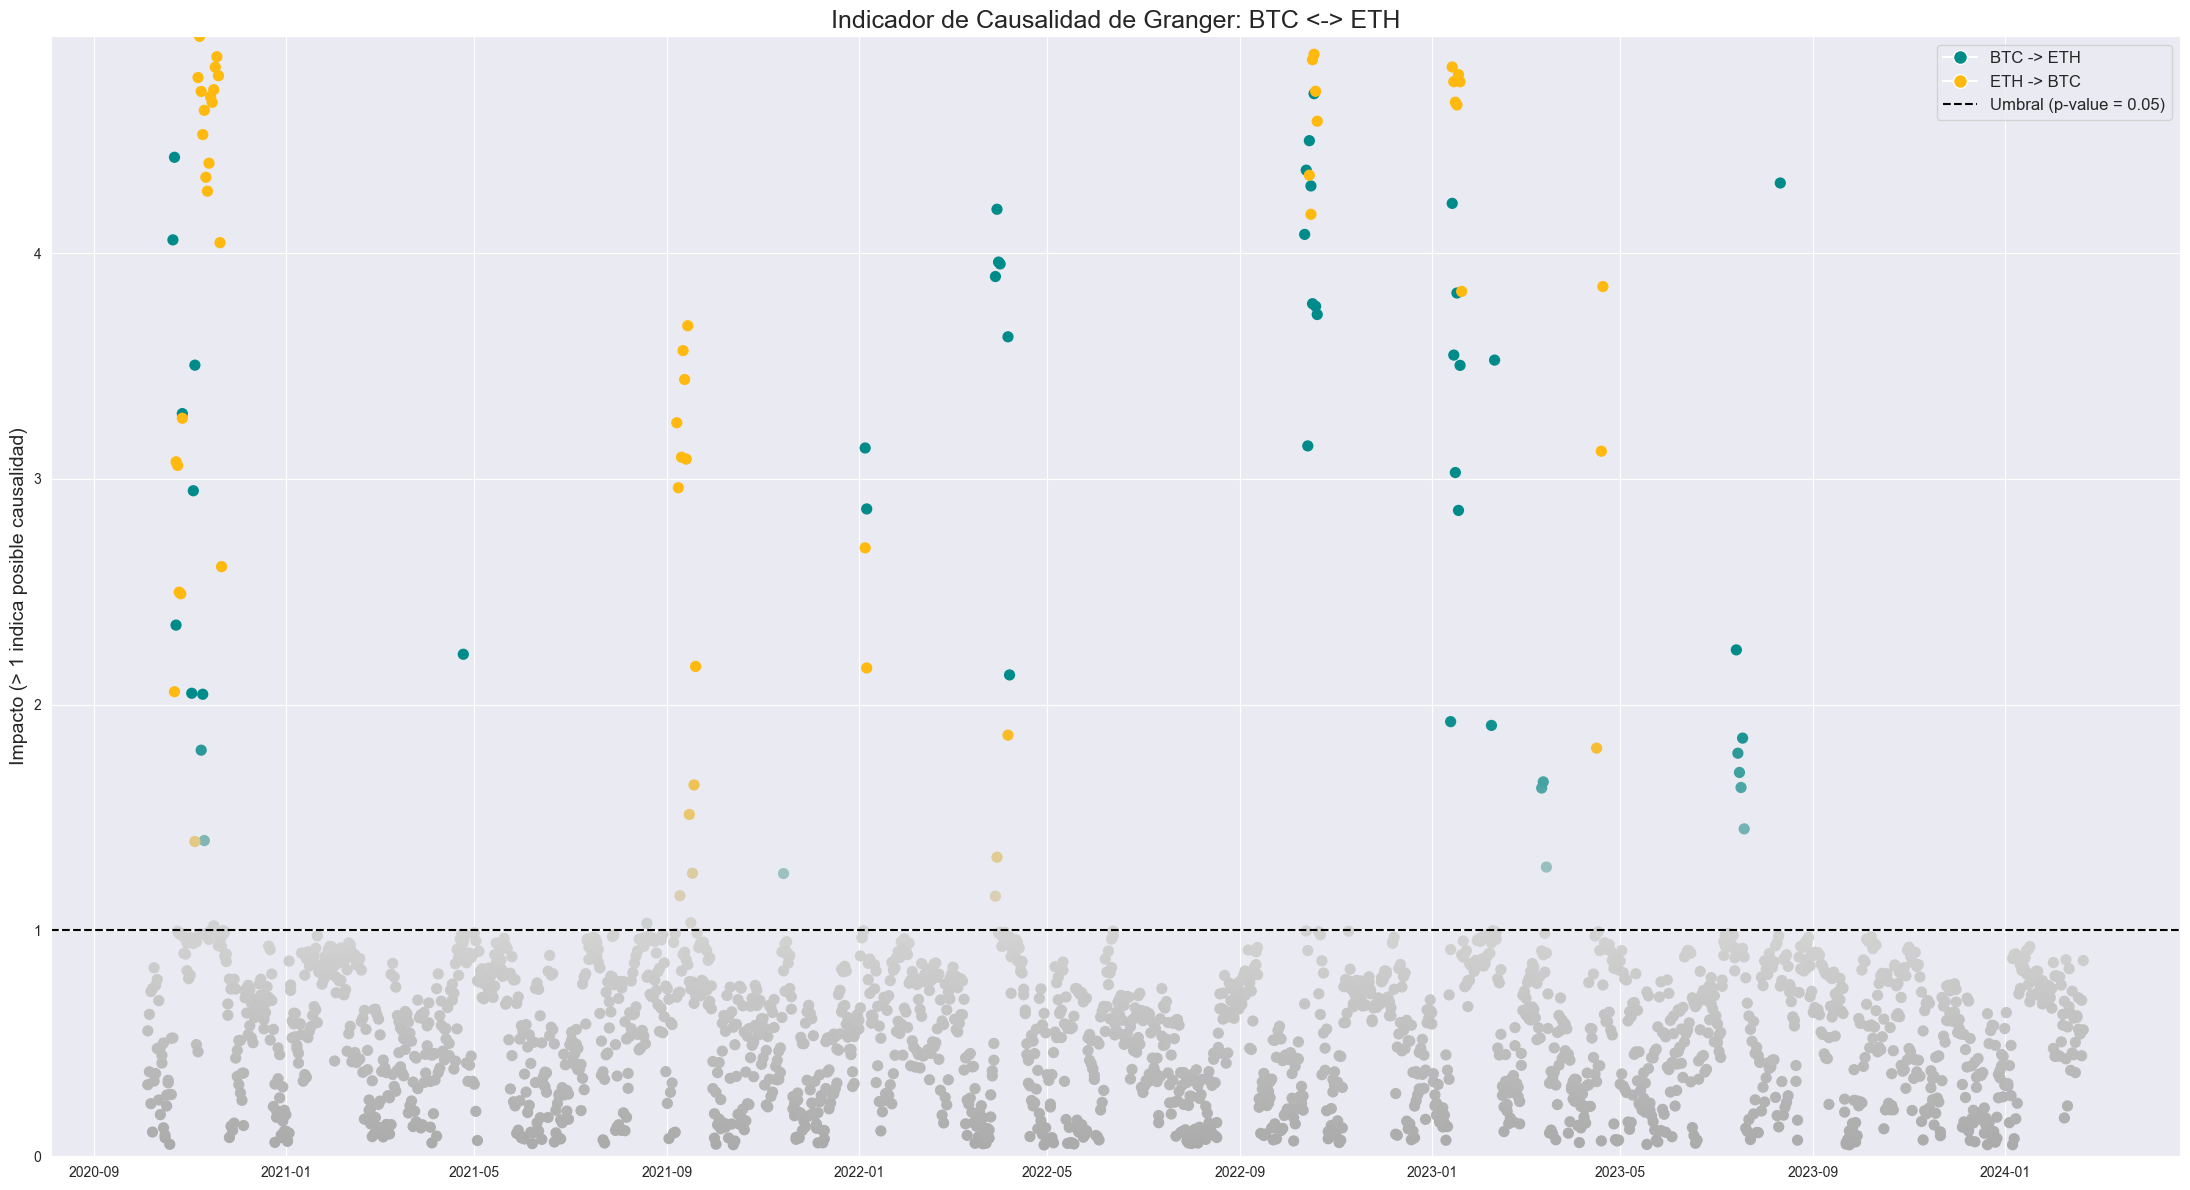

In [375]:
ind = granger_window_comp_index(res)
granger_comp_index_plot(ind, 'BTC', 'ETH')

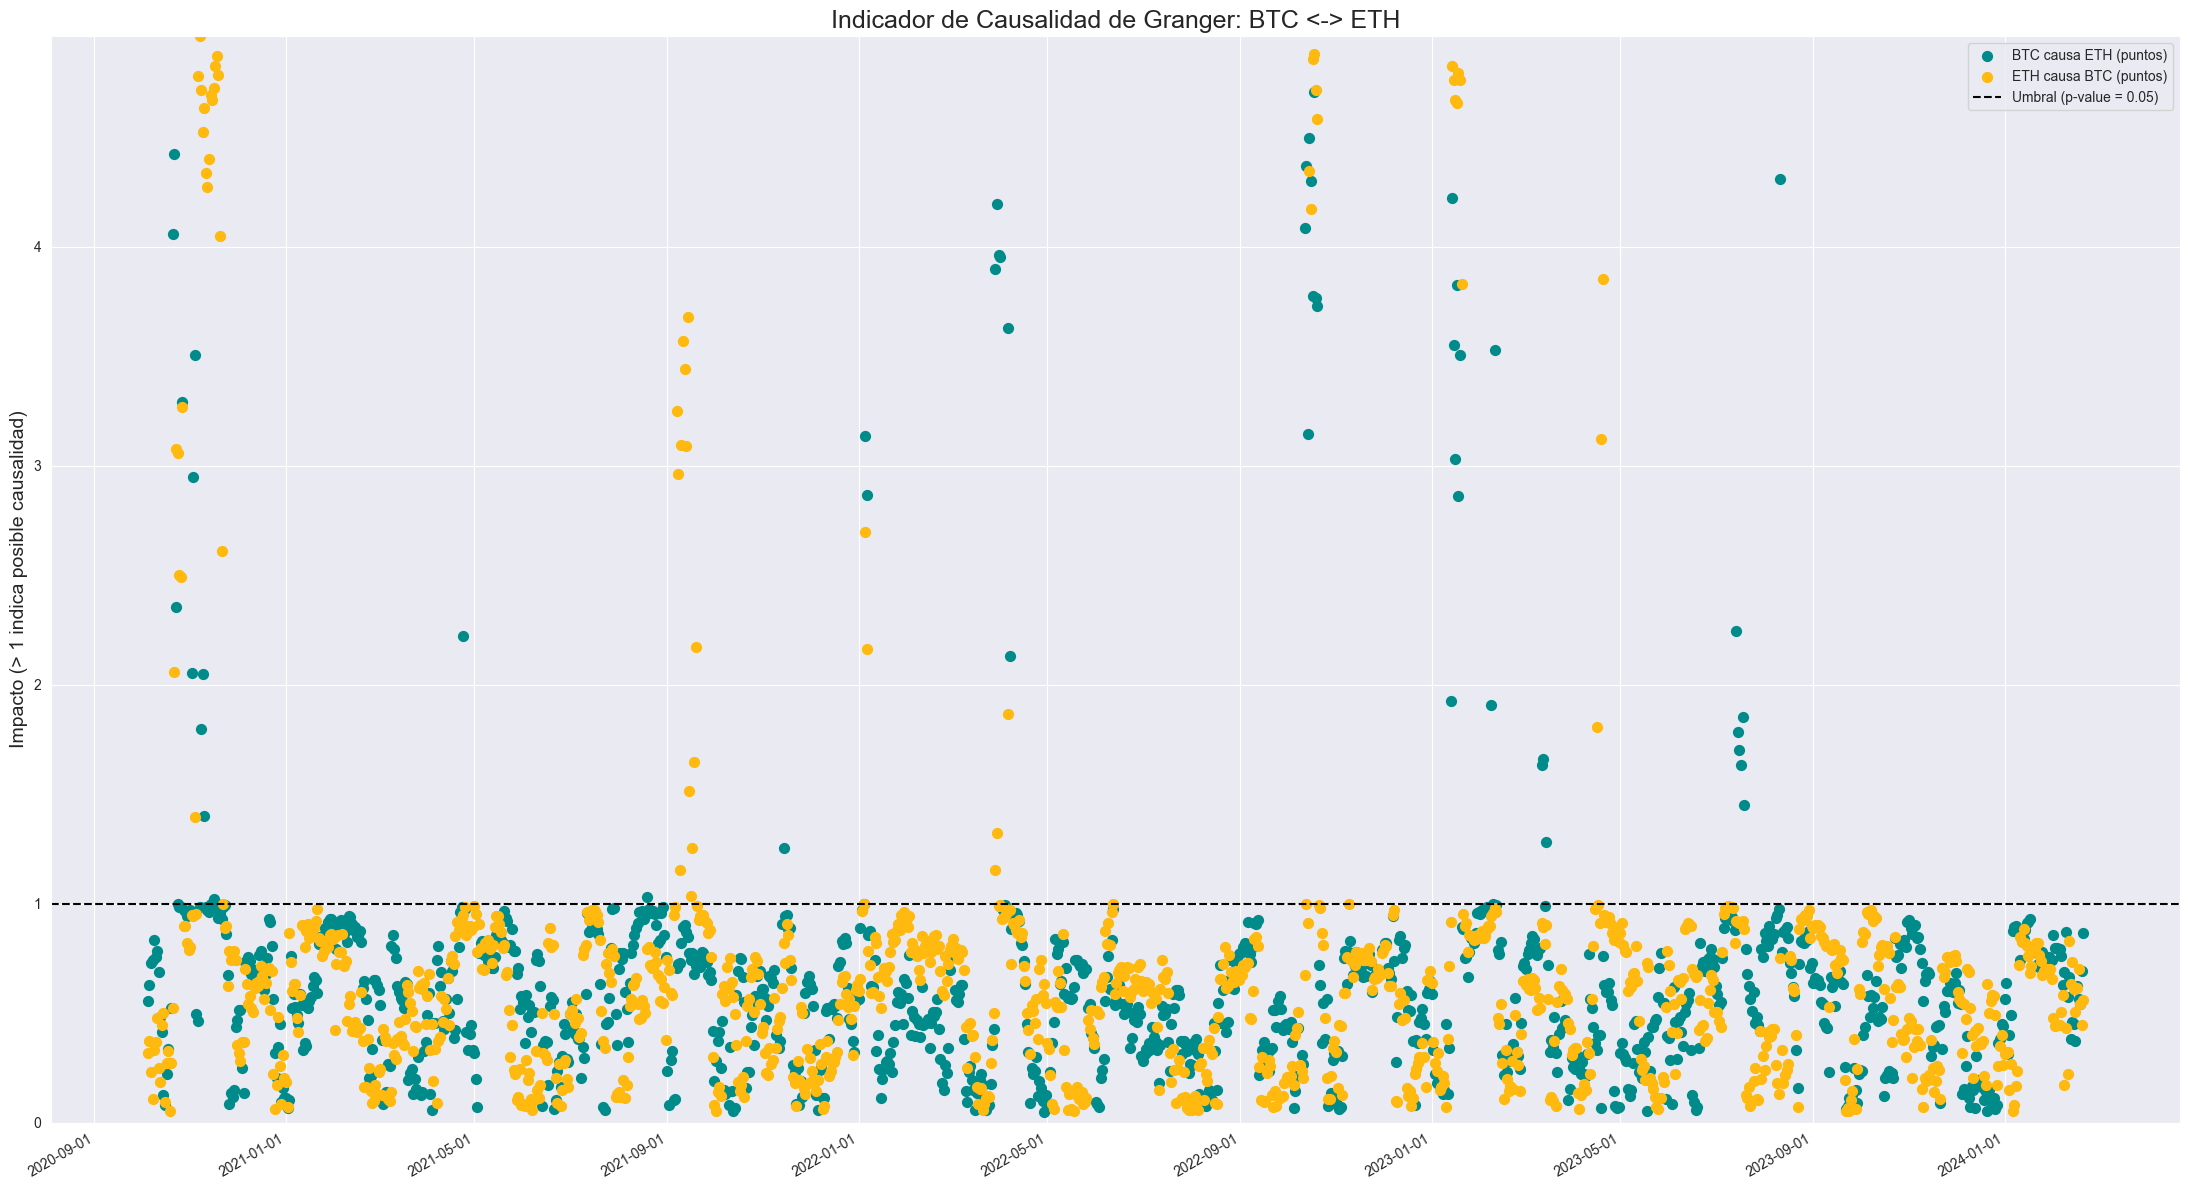

In [373]:
granger_comp_index_plot2(ind, 'BTC', 'ETH')

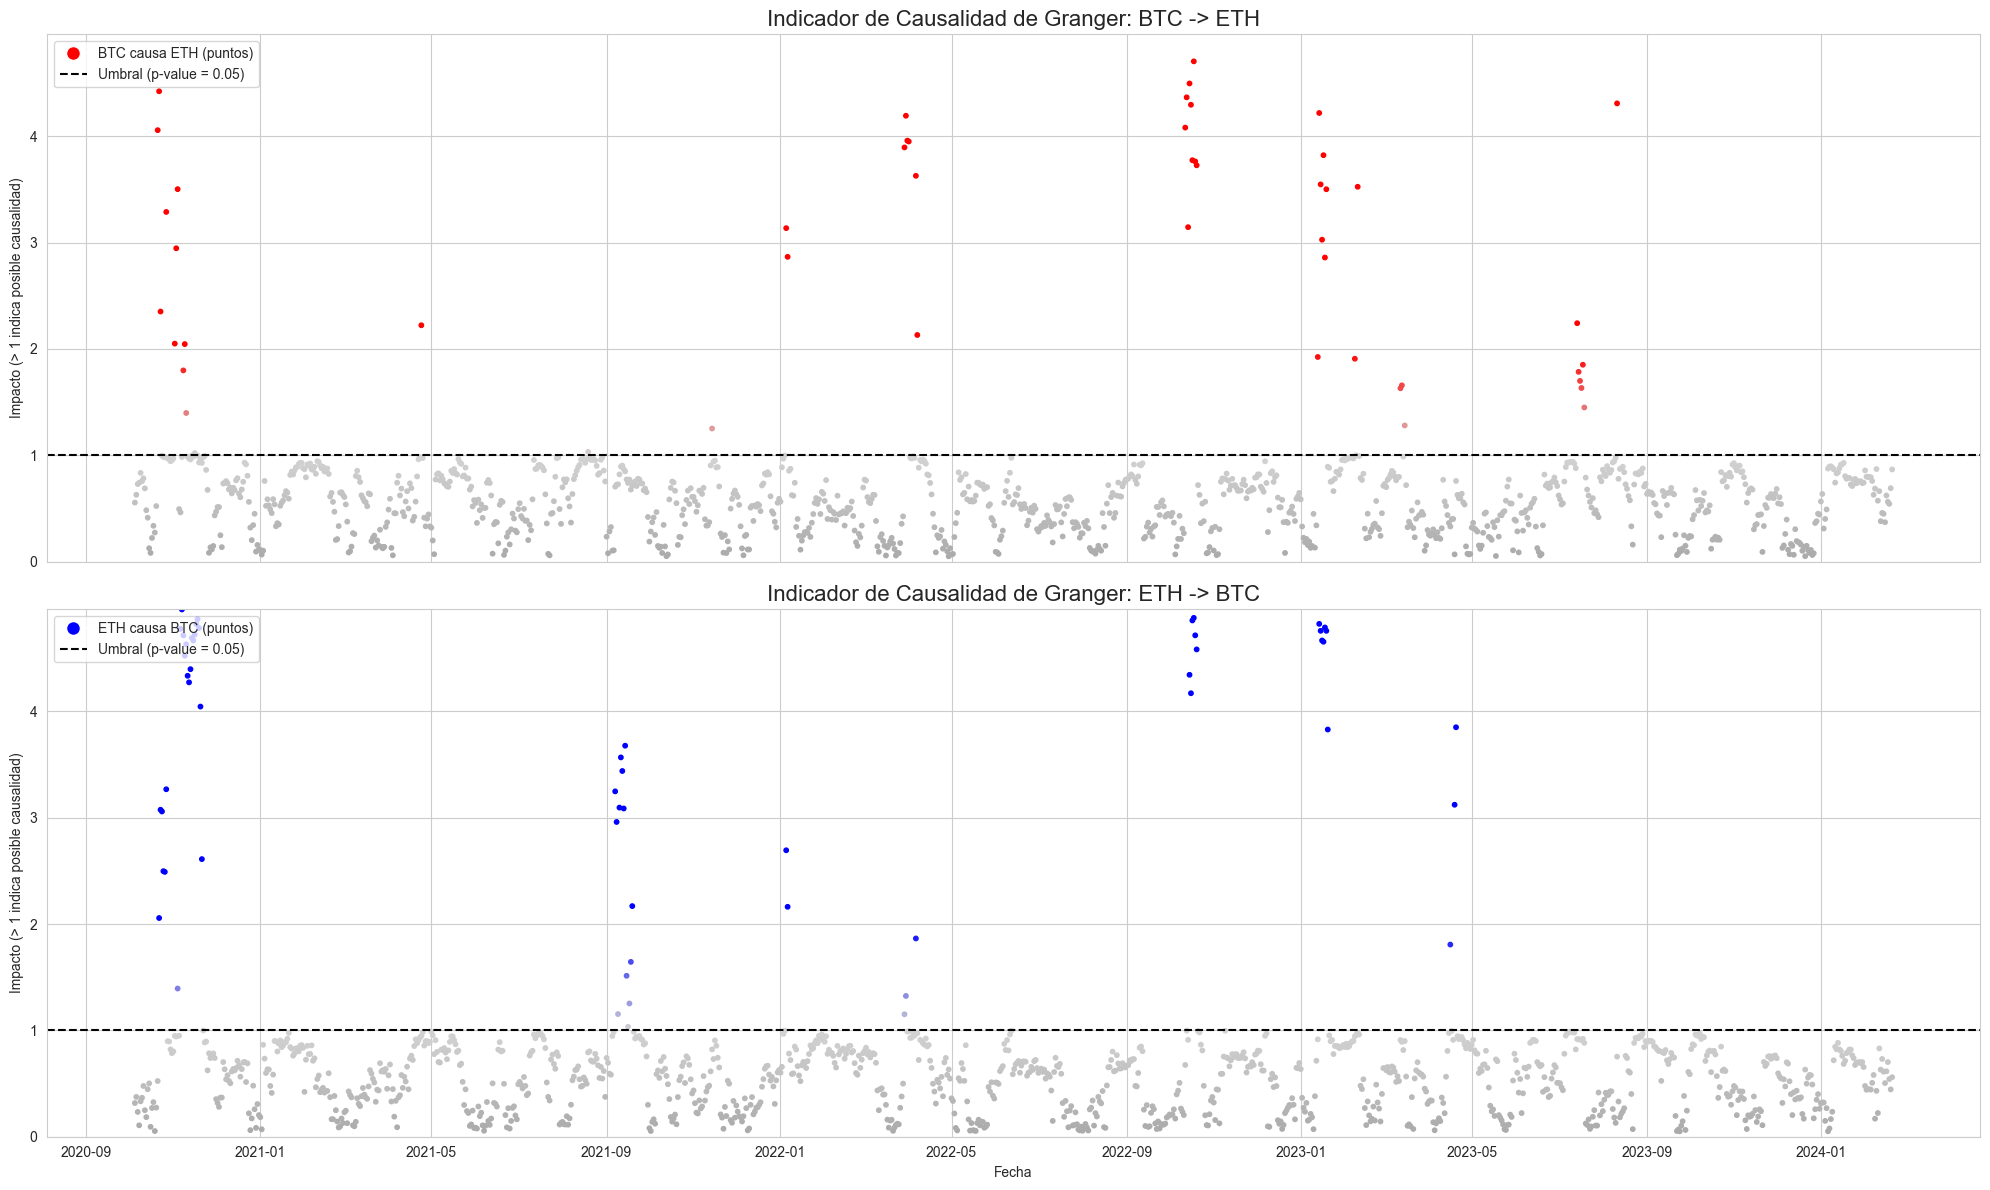

In [311]:
granger_comp_index_sep_plots(ind, 'BTC', 'ETH')

#### Oscilador

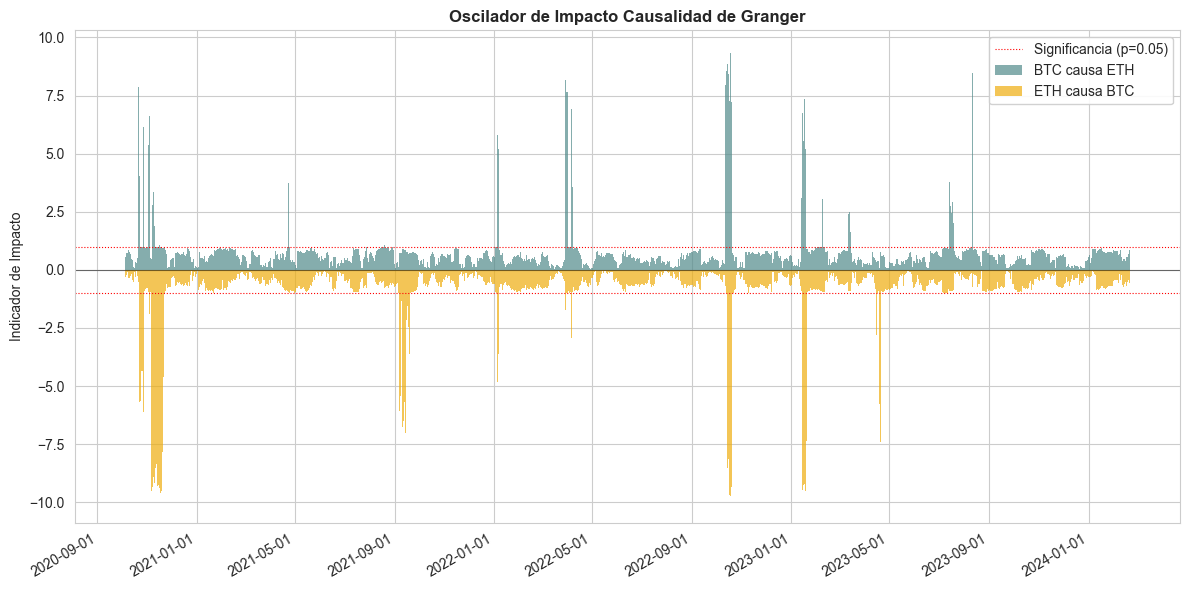

In [313]:
osc = granger_oscillator(res)
granger_oscillator_plot(osc, 'BTC', 'ETH')

#### Indice de impacto

In [334]:
imp = impact_index(res)
imp.head()

,fecha,p_value_1_2,p_value_2_1,indice_impacto
30,2020-10-05,0.494585,0.733090,-1.728025
31,2020-10-06,0.421456,0.675752,0.999923
32,2020-10-07,0.320524,0.816998,2.555197
33,2020-10-08,0.307866,0.942663,3.298283
34,2020-10-09,0.215339,0.716932,2.449359


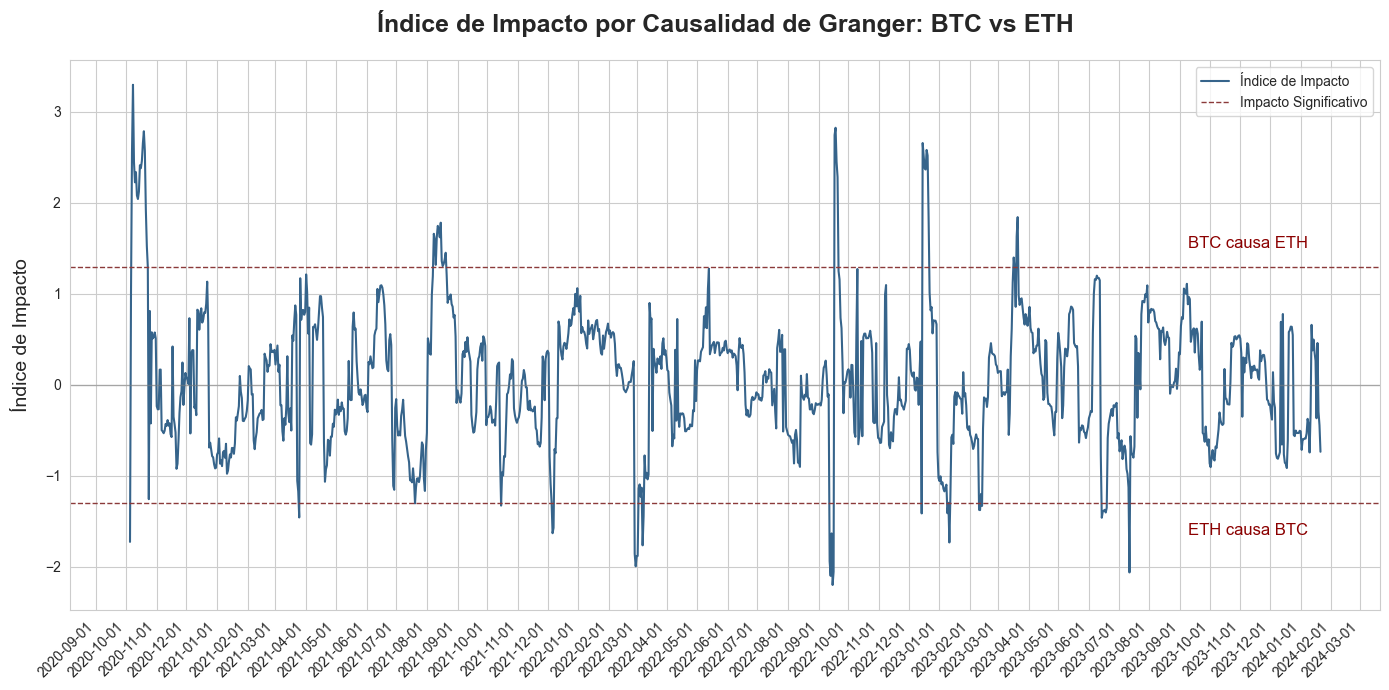

In [350]:
impact_index_plot(imp, 'BTC', 'ETH')

### Graficas Horarias